In [1]:
!pip install --quiet git+https://github.com/ain3007-project/project-utils.git

In [2]:
import huggingface_hub as hfh
import os
import pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path
import openslide
import numpy as np
from PIL import Image
from project_utils.preprocessing import expand2square
from project_utils.plotting import plot_image_mask_by_path

In [3]:
hfh.login("INSERT TOKEN HERE")

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
train_df = pd.read_csv("/kaggle/input/prostate-cancer-grade-assessment/train.csv")
test_df = pd.read_csv("/kaggle/input/prostate-cancer-grade-assessment/test.csv")
submission_df = pd.read_csv("/kaggle/input/prostate-cancer-grade-assessment/sample_submission.csv")

In [5]:
train_df.shape, test_df.shape, submission_df.shape

((10616, 4), (3, 2), (3, 2))

In [6]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [7]:
image_size = 512
pad_images = True
# padding_color = "white"

output_repo_id = f"ain3007-project/panda-dataset-thumbnails-{image_size}"

if pad_images:
    output_repo_id += "-padded"
#     output_repo_id += f"-{padding_color}"

hfh.create_repo(output_repo_id, private=True, repo_type="dataset", exist_ok=True)

RepoUrl('https://huggingface.co/datasets/ain3007-project/panda-dataset-thumbnails-512-padded', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ain3007-project/panda-dataset-thumbnails-512-padded')

In [8]:
!mkdir -p images masks

In [9]:
metadata_df = train_df.copy()
metadata_df["image-dimension_x"] = 0
metadata_df["image-dimension_y"] = 0
metadata_df["image-levels"] = 0
metadata_df["image-format"] = ""
metadata_df["mask-dimension_x"] = 0
metadata_df["mask-dimension_y"] = 0
metadata_df["mask-levels"] = 0
metadata_df["mask-format"] = ""

In [10]:
image_folder = Path("/kaggle/input/prostate-cancer-grade-assessment/train_images")
mask_folder = Path("/kaggle/input/prostate-cancer-grade-assessment/train_label_masks")

total_size = train_df.shape[0]
for idx, row in tqdm(train_df.iterrows(), total=total_size):
    image_filename = row["image_id"] + ".tiff"
    mask_filename = row["image_id"] + "_mask.tiff"
    
    # read thumbnail of both image and mask and save as png to a folder
    try:
        image = openslide.OpenSlide(image_folder / image_filename)
    except:
        print(f"There was an error during image {idx}")
        continue

    try:
        mask = openslide.OpenSlide(mask_folder / mask_filename)
    except:
        print(f"There was an error during mask {idx}")
        continue

    image_thumbnail = image.get_thumbnail((image_size, image_size))
    mask_thumbnail = mask.get_thumbnail((image_size, image_size))
    mask_thumbnail = np.array(mask_thumbnail)[:, :, 0]
    
    if row["data_provider"] == "radboud":
        # merge 1 2 3 4 5 into 1
        mask_thumbnail[mask_thumbnail == 2] = 1
        mask_thumbnail[mask_thumbnail == 3] = 1
        mask_thumbnail[mask_thumbnail == 4] = 1
        mask_thumbnail[mask_thumbnail == 5] = 1
        
        
    elif row["data_provider"] == "karolinska":
        # merge 1 2 into 1 
        mask_thumbnail[mask_thumbnail == 2] = 1


    # multiply by 255 to get the correct color
    mask_thumbnail = mask_thumbnail * 255
    mask_thumbnail = Image.fromarray(mask_thumbnail)
    
    if pad_images:
        image_thumbnail = expand2square(image_thumbnail, "white")
        mask_thumbnail = expand2square(mask_thumbnail, "black")

    
    image_thumbnail.save(f"images/{idx}.png")
    mask_thumbnail.save(f"masks/{idx}.png")


    # also add metadata processors
    metadata_df.loc[idx, "image-dimension_x"] = image.dimensions[0]
    metadata_df.loc[idx, "image-dimension_y"] = image.dimensions[1]
    metadata_df.loc[idx, "image-levels"] = image.level_count
    metadata_df.loc[idx, "image-format"] = image.properties["openslide.vendor"]

    metadata_df.loc[idx, "mask-dimension_x"] = mask.dimensions[0]
    metadata_df.loc[idx, "mask-dimension_y"] = mask.dimensions[1]
    metadata_df.loc[idx, "mask-levels"] = mask.level_count
    metadata_df.loc[idx, "mask-format"] = mask.properties["openslide.vendor"]
    
    image.close()
    mask.close()
    
    if idx % 100 == 0:
        print(f"{idx} done {idx/total_size}")

metadata_df.head()

  0%|          | 0/10616 [00:00<?, ?it/s]

0 done 0.0
100 done 0.009419743782969104
There was an error during mask 157
200 done 0.018839487565938208
There was an error during mask 224
300 done 0.02825923134890731
400 done 0.037678975131876416
500 done 0.04709871891484552
There was an error during mask 519
There was an error during mask 588
600 done 0.05651846269781462
There was an error during mask 690
700 done 0.06593820648078372
There was an error during mask 779
There was an error during mask 780
800 done 0.07535795026375283
There was an error during mask 817
There was an error during mask 847
900 done 0.08477769404672193
1000 done 0.09419743782969103
There was an error during mask 1016
There was an error during mask 1055
1100 done 0.10361718161266013
1200 done 0.11303692539562923
1300 done 0.12245666917859835
1400 done 0.13187641296156744
1500 done 0.14129615674453655
1600 done 0.15071590052750566
1700 done 0.16013564431047475
There was an error during mask 1706
1800 done 0.16955538809344387
There was an error during mask 1

,image_id,data_provider,isup_grade,gleason_score,image-dimension_x,image-dimension_y,image-levels,image-format,mask-dimension_x,mask-dimension_y,mask-levels,mask-format
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,27648,29440,3,generic-tiff,27648,29440,3,generic-tiff
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,15360,13312,3,generic-tiff,15360,13312,3,generic-tiff
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,5888,25344,3,generic-tiff,5888,25344,3,generic-tiff
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,23904,28664,3,generic-tiff,23904,28664,3,generic-tiff
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,28672,34560,3,generic-tiff,28672,34560,3,generic-tiff


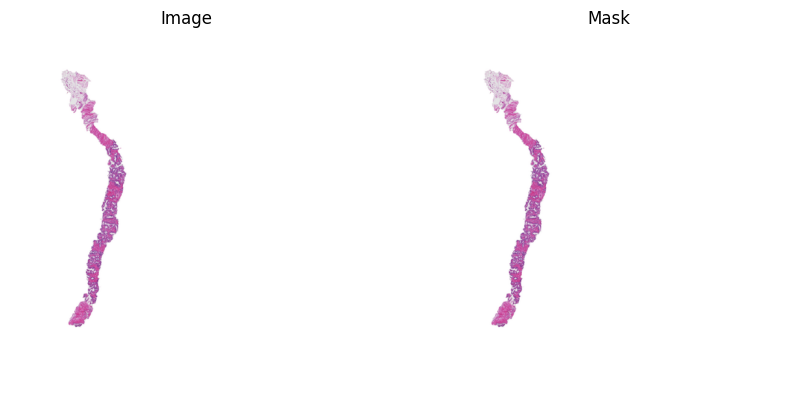

In [11]:
plot_image_mask_by_path("images/0.png", "images/0.png")

In [12]:
metadata_df.to_csv("metadata.csv", index=False)

In [13]:
!zip -r images.zip images
!zip -r masks.zip masks

api = hfh.HfApi()

api.upload_file(
    path_or_fileobj="images.zip",
    path_in_repo="images.zip",
    repo_id=output_repo_id,
    repo_type="dataset",
)

api.upload_file(
    path_or_fileobj="masks.zip",
    path_in_repo="masks.zip",
    repo_id=output_repo_id,
    repo_type="dataset",
)

api.upload_file(
    path_or_fileobj="metadata.csv",
    path_in_repo="metadata.csv",
    repo_id=output_repo_id,
    repo_type="dataset",
)

  adding: images/ (stored 0%)
  adding: images/3023.png (deflated 6%)
  adding: images/6845.png (deflated 3%)
  adding: images/8227.png (deflated 6%)
  adding: images/1613.png (deflated 1%)
  adding: images/6554.png (deflated 2%)
  adding: images/6927.png (deflated 2%)
  adding: images/1099.png (deflated 7%)
  adding: images/9086.png (deflated 7%)
  adding: images/5849.png (deflated 5%)
  adding: images/7118.png (deflated 1%)
  adding: images/7372.png (deflated 1%)
  adding: images/8729.png (deflated 1%)
  adding: images/3757.png (deflated 1%)
  adding: images/5898.png (deflated 1%)
  adding: images/3314.png (deflated 12%)
  adding: images/2658.png (deflated 6%)
  adding: images/3804.png (deflated 3%)
  adding: images/9065.png (deflated 1%)
  adding: images/6038.png (deflated 2%)
  adding: images/5688.png (deflated 3%)
  adding: images/6854.png (deflated 3%)
  adding: images/6004.png (deflated 1%)
  adding: images/3587.png (deflated 2%)
  adding: images/1433.png (deflated 6%)
  adding:

images.zip:   0%|          | 0.00/507M [00:00<?, ?B/s]

masks.zip:   0%|          | 0.00/24.3M [00:00<?, ?B/s]

'https://huggingface.co/datasets/ain3007-project/panda-dataset-thumbnails-512-padded/blob/main/metadata.csv'